# Predicting Hotel Cancellations

## 🏨 Background

This project is supporting a hotel aimed to increase revenue from their room bookings. They believe that they can use data science to help them reduce the number of cancellations. We are tasked with using appropriate methodology to identify what contributes to whether a booking will be fulfilled or cancelled. The hotel intends to use the results of this project to reduce the chance someone cancels their booking.

There are two questions to this problem:
1. What is causing people to cancel their bookings?
2. Can we build a model to predict which bookings will be cancelled?

Since the second question uses prediction modelling which is a subject I am not familiar with yet, I will use basic EDA (exploratory data analysis) to answer some statistical questions about the data and give some suggestions based on that. This will give us an idea of what might be causing cancellations. In the near future, I aim to come back to this problem and solve the second question. 

In [1]:
# import all the libraries you'll need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

hotels = pd.read_csv("/kaggle/input/hotel-bookings/hotel_bookings.csv")
hotels.head()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not_Canceled
1,INN00002,2.0,0.0,2.0,3.0,Not Selected,0.0,Room_Type 1,5.0,2018.0,11.0,6.0,Online,0.0,0.0,0.0,106.68,1.0,Not_Canceled
2,INN00003,1.0,0.0,2.0,1.0,Meal Plan 1,0.0,Room_Type 1,1.0,2018.0,2.0,28.0,Online,0.0,0.0,0.0,60.00,0.0,Canceled
3,INN00004,2.0,0.0,0.0,2.0,Meal Plan 1,0.0,Room_Type 1,211.0,2018.0,5.0,20.0,Online,0.0,0.0,0.0,100.00,0.0,Canceled
4,INN00005,2.0,0.0,1.0,1.0,Not Selected,0.0,Room_Type 1,48.0,2018.0,4.0,11.0,Online,0.0,0.0,0.0,94.50,0.0,Canceled


## The Data

They have provided us with their bookings data in a file called `hotel_bookings.csv`, which contains the following:

| Column     | Description              |
|------------|--------------------------|
| `Booking_ID` | Unique identifier of the booking. |
| `no_of_adults` | The number of adults. |
| `no_of_children` | The number of children. |
| `no_of_weekend_nights` | Number of weekend nights (Saturday or Sunday). |
| `no_of_week_nights` | Number of week nights (Monday to Friday). |
| `type_of_meal_plan` | Type of meal plan included in the booking. |
| `required_car_parking_space` | Whether a car parking space is required. |
| `room_type_reserved` | The type of room reserved. |
| `lead_time` | Number of days before the arrival date the booking was made. |
| `arrival_year` | Year of arrival. |
| `arrival_month` | Month of arrival. |
| `arrival_date` | Date of the month for arrival. |
| `market_segment_type` | How the booking was made. |
| `repeated_guest` | Whether the guest has previously stayed at the hotel. |
| `no_of_previous_cancellations` | Number of previous cancellations. |
| `no_of_previous_bookings_not_canceled` | Number of previous bookings that were canceled. |
| `avg_price_per_room` | Average price per day of the booking. |
| `no_of_special_requests` | Count of special requests made as part of the booking. |
| `booking_status` | Whether the booking was cancelled or not. |

Source (data has been modified): https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

In [2]:
# count the number of null values in each column and find the percentage compared to the whole column
print(pd.DataFrame({'Number of null values in column:' : hotels.isna().sum(), 
                    'Precentage of null values:' : round(hotels.isna().mean()*100,2)}))

                                      Number of null values in column:  \
Booking_ID                                                           0   
no_of_adults                                                       413   
no_of_children                                                     324   
no_of_weekend_nights                                               367   
no_of_week_nights                                                  807   
type_of_meal_plan                                                  526   
required_car_parking_space                                        2592   
room_type_reserved                                                1171   
lead_time                                                          472   
arrival_year                                                       378   
arrival_month                                                      504   
arrival_date                                                       981   
market_segment_type                   

In [3]:
# determine if there are any bookings where the number of adults and the number of children columns are equal to zero at the same time
people = hotels[(hotels['no_of_adults'] == 0) & (hotels['no_of_children'] == 0)]
people

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status


# Data Cleaning

To address the null values in the dataset, we look at each column individually to see if removing or changing the null values is the best course of action. Using the information we have, we can impute probable estimated values into the dataset instead of just removing unknown values. This will help preserve more data points since we have over 12,000 null values. 

1. The number of adult & children columns cannot both be zero at the same time. It also does not make sense to impute the mean value of guests since less than 2% of these columns have null values.
2. For the number of week and weekend nights booked, the median values (week nights = 2, weekend nights = 1) are used to replace any null values. 
3. The null values in columns with object type data (room type, meal plan & market segment type) is changed to 'Unknown' which creates another category for the data to fall in. 
4. Required parking space & special request null values are changed to zero, assuming that customers might have overlooked this option because they do not have a preference (meaning their input would probably have been 0).
5. Lead time null values are replaced by imputing the mean and rounding it to a whole number.
6. Average room price null values are replaced by imputing the mean and rounding it to 2 decimals. 
7. For all other numeric values we drop the null values since we cannot make assumptions based on the information we have.

In [4]:
# calculate the mean or median of a column to use when imputing null values
round(hotels['avg_price_per_room'].mean(), 2)
hotels['no_of_week_nights'].median()
hotels['no_of_weekend_nights'].median()
round(hotels['lead_time'].mean())

# create a new catagory 'Unknown' and replace null values in catagorical data columns
hotels['room_type_reserved'] = hotels['room_type_reserved'].fillna('Unknown')
hotels['type_of_meal_plan'] = hotels['type_of_meal_plan'].fillna('Unknown')
hotels['market_segment_type'] = hotels['market_segment_type'].fillna('Unknown')

# change null values into zero where it would have probably been zero
hotels['required_car_parking_space'] = hotels['required_car_parking_space'].fillna(0)
hotels['no_of_special_requests'] = hotels['no_of_special_requests'].fillna(0)

# change null values into the mean and median
hotels['no_of_week_nights'] = hotels['no_of_week_nights'].fillna(hotels['no_of_week_nights'].median())
hotels['no_of_weekend_nights'] = hotels['no_of_weekend_nights'].fillna(hotels['no_of_weekend_nights'].median())

hotels['lead_time'] = hotels['lead_time'].fillna(round(hotels['lead_time'].mean()))
hotels['avg_price_per_room'] = hotels['avg_price_per_room'].fillna(round(hotels['avg_price_per_room'].mean(),2))

# drop the rest of the null values
hotels_clean = hotels.dropna()

Text(0.5, 1.0, 'Number of bookings with special requests (cancelled vs not-canceled)')

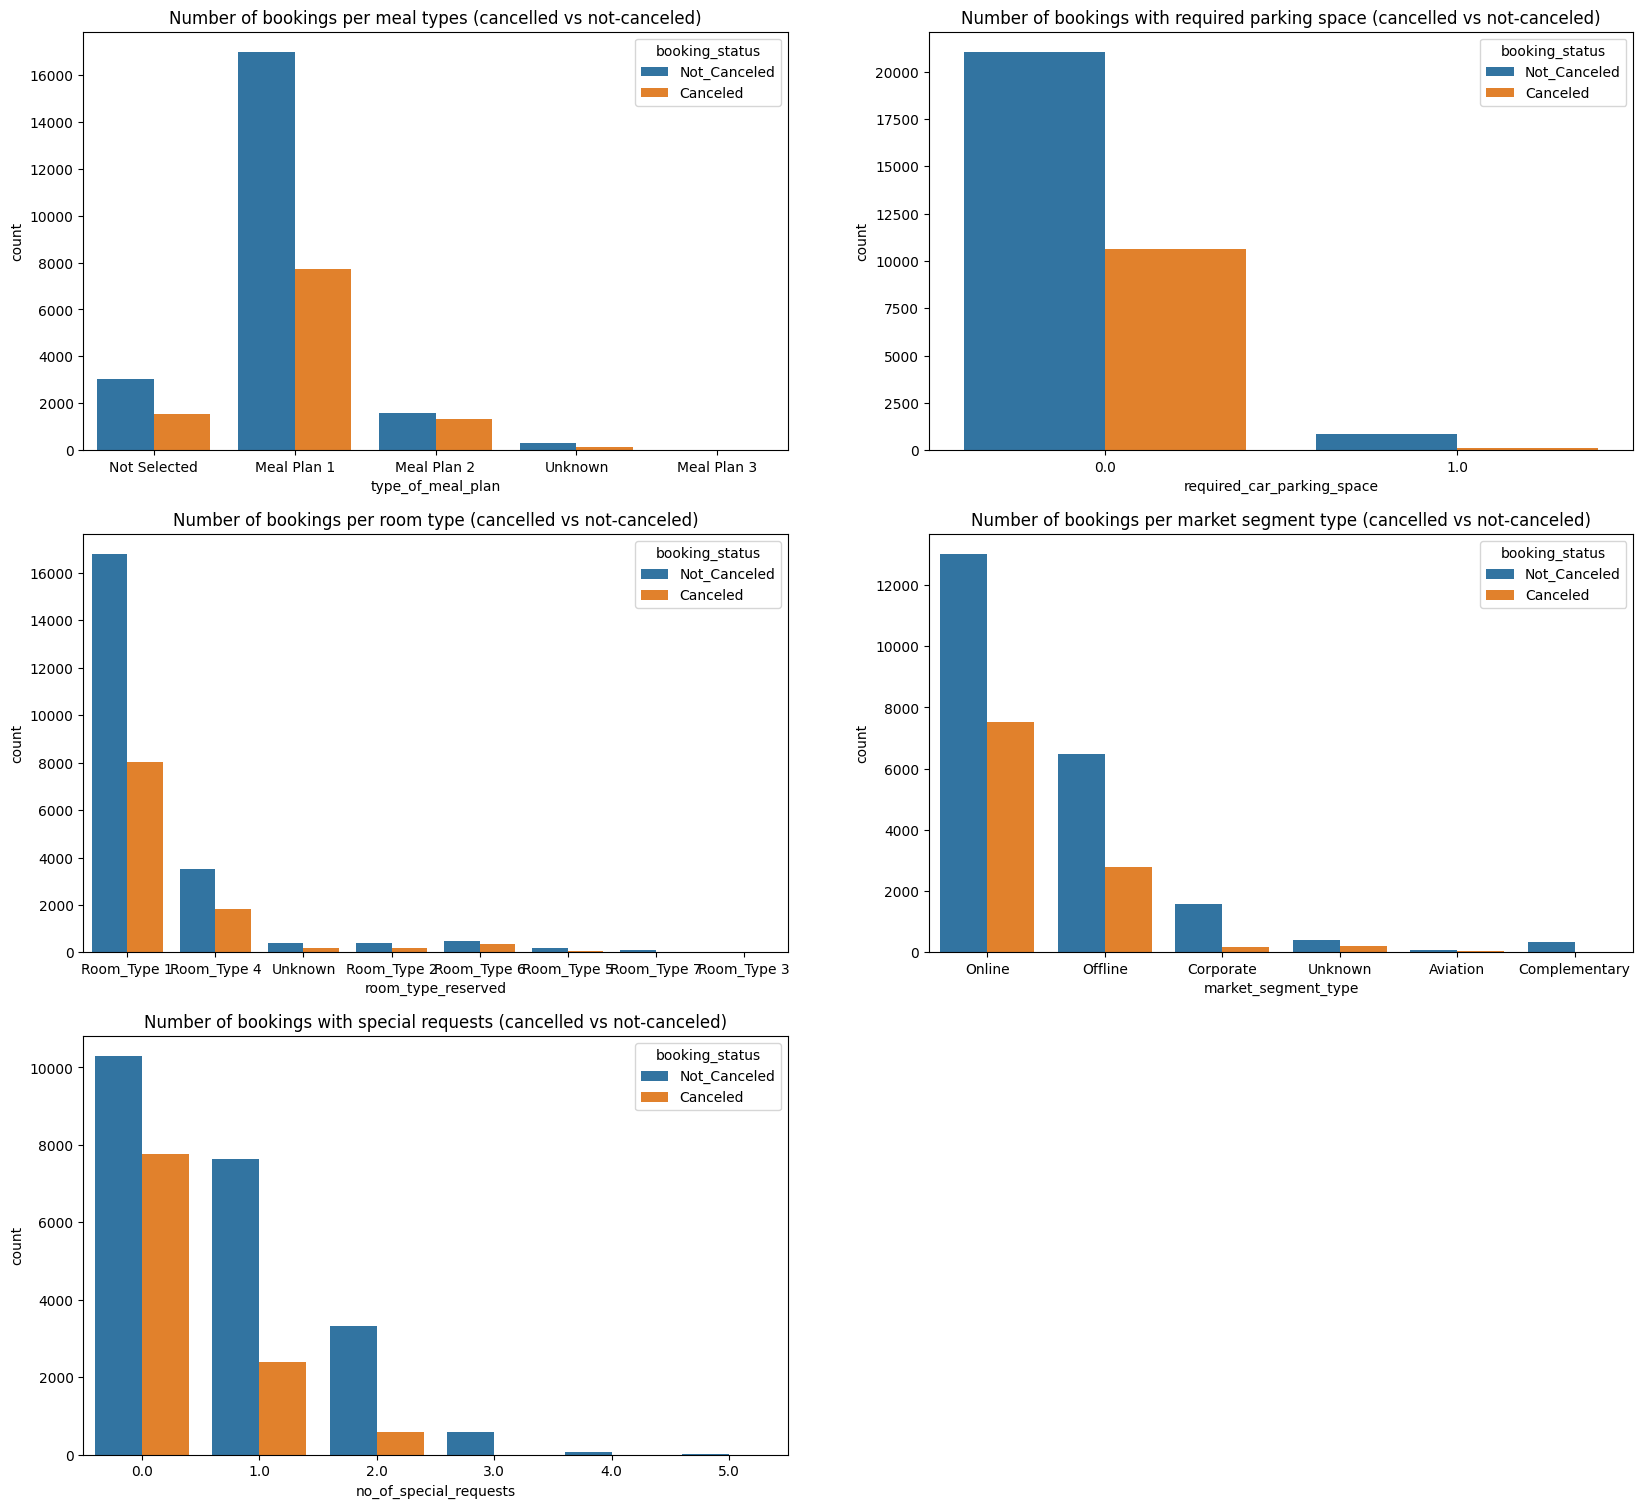

In [5]:
# create histograms to show basi distribution of categorical data
plt.figure(figsize = (20,25))

plt.subplot(4,2,1)
sns.countplot(data=hotels_clean, x='type_of_meal_plan', hue='booking_status')
plt.title('Number of bookings per meal types (cancelled vs not-canceled)')

plt.subplot(4,2,2)
sns.countplot(data=hotels_clean, x='required_car_parking_space', hue='booking_status')
plt.title('Number of bookings with required parking space (cancelled vs not-canceled)')

plt.subplot(4,2,3)
sns.countplot(data=hotels_clean, x='room_type_reserved', hue='booking_status')
plt.title('Number of bookings per room type (cancelled vs not-canceled)')

plt.subplot(4,2,4)
sns.countplot(data=hotels_clean, x='market_segment_type', hue='booking_status')
plt.title('Number of bookings per market segment type (cancelled vs not-canceled)')

plt.subplot(4,2,5)
sns.countplot(data=hotels_clean, x='no_of_special_requests', hue='booking_status')
plt.title('Number of bookings with special requests (cancelled vs not-canceled)')

Using a couple of histograms for canceled vs not-canceled bookings, we generate a quick idea of what customers are interested in when they make a booking. We can see that Meal Plan 1 and Room Type 1 are the most popular options. Customers tend to cancel bookings less when they have at least one special requests. Most people book online and required car parking does not seem to have a major effect on booking cancellations. 

# Data Analysis

In order to create a clearer picture of what a successful booking looks like, we can split the data using the Booking Status column and create two new dataframes. This will also give a more in depth understanding of what influences customers to cancel. 
- the Canceled dataframe has 10,737 entries
- the Not-canceled dataframe has 21,901 entries

This suggests that currently, around 49% of all bookings get canceled. 

In [6]:
# split the data by booking status to create new dataframes
canceled = hotels_clean[hotels_clean['booking_status'] == 'Canceled']

not_canceled = hotels_clean[hotels_clean['booking_status'] == 'Not_Canceled']

/tmp/ipykernel_20/1739543848.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot1.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], rotation=90)


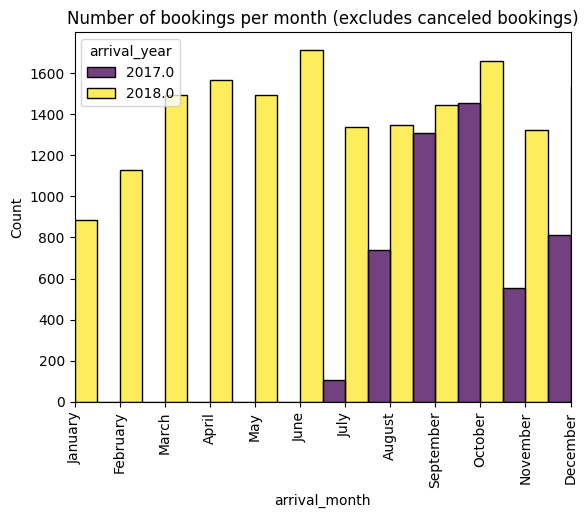

In [7]:
# create a histogram to show the distribution of monthly bookings excluding cancelled bookings
plot1 = sns.histplot(data=not_canceled, x='arrival_month', hue='arrival_year', multiple='dodge', discrete=True, palette='viridis')
plot1.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], rotation=90)

plot1.set_title('Number of bookings per month (excludes canceled bookings)')
plot1.set_xlim(1,12)
plot1.set_xticks(range(1,13))

The histogram above shows that the hotel is more popular during the Spring, Summer and Fall - especially during April, June & October. However, the histogram below suggests that the time of year of the booking has no clear effect on a cancelled booking.

/tmp/ipykernel_20/4070572000.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot2.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], rotation=90)


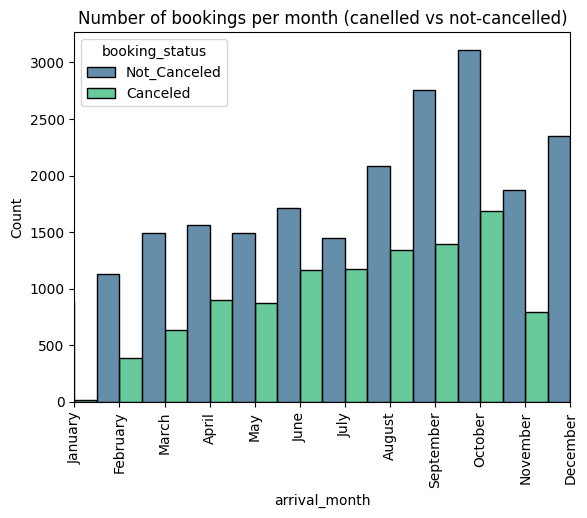

In [8]:
# create a histogram ot see the distribution of monthly bookings for cancelled vs not-cancelled bookings
plot2 = sns.histplot(data=hotels_clean, x='arrival_month', hue='booking_status', multiple='dodge', discrete=True, palette='viridis')

plot2.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], rotation=90)

plot2.set_title('Number of bookings per month (canelled vs not-cancelled)')
plot2.set_xlim(1,12)
plot2.set_xticks(range(1,13))

In [9]:
# look at the difference between cancelled bookings for repeat guests vs not-cancelled bookings
count_repeated_c = canceled['repeated_guest'].value_counts()
count_repeated_nc = not_canceled['repeated_guest'].value_counts()

print(f'There were {count_repeated_c.iloc[1]} repeated guests who canceled bookings')
print(f'There were {count_repeated_nc.iloc[1]} repeated guests who did not cancel bookings')

There were 15 repeated guests who canceled bookings
There were 829 repeated guests who did not cancel bookings


Even though repeated guests make up a small percentage of overall bookings, they tend to honour their booking and cancel less than non-repeat guests. 

[Text(0.5, 1.0, 'Number of cancelled vs honoured bokings based on lead time')]

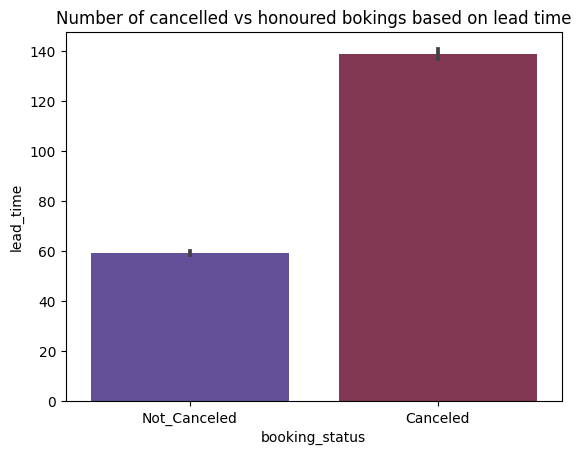

In [10]:
plot3 = sns.barplot(data=hotels_clean, x='booking_status', y='lead_time', palette='twilight')
plot3.set(title='Number of cancelled vs honoured bokings based on lead time')

It's important to notice that lead time plays a major role in whether or not a booking is cancelled. The longer lead times tend to be cacnelled more often than shorter lead times. For average price, the story is a bit different. When we look at the average room price dataset as a whole there is clearly a large amount of outliers. 

When we remove the outliers in our average price per room column, it gives a clearer picture of the spread of the average price range. With the image below, we can see that a cancelled booking tend to have a higher average room price while an honoured booking tends to have a lower average room price. 

Text(0.5, 1.0, 'Average price per room for cancelled vs honoured bookings (outliers removed)')

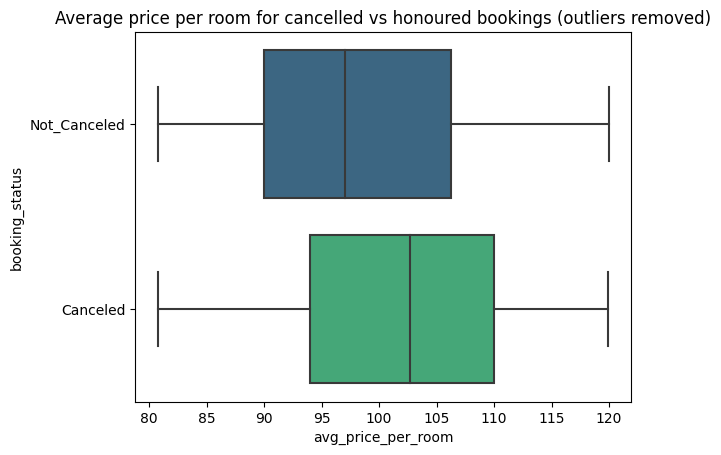

In [11]:
# calculate the first quartile, third quartile and IQR
Q1 = hotels_clean['avg_price_per_room'].quantile(0.25)
Q3 = hotels_clean['avg_price_per_room'].quantile(0.75)
IQR = Q3 - Q1

avg_price_range_less = hotels_clean.loc[(hotels_clean['avg_price_per_room'] > Q1) &
                                        (hotels_clean['avg_price_per_room'] < Q3)]

# create a boxplot to show the distribution of average room price without outliers
plot5 = sns.boxplot(data=avg_price_range_less, x='avg_price_per_room', y='booking_status', palette='viridis')
plot5.set_title('Average price per room for cancelled vs honoured bookings (outliers removed)')

There does not seem to be a clear correlation between the average room price and how many days a customer chooses to stay. The graph below does suggest that a large majority of bookings tend to be less than 5 days, and the majority of stays longer than 10 days are cancelled.

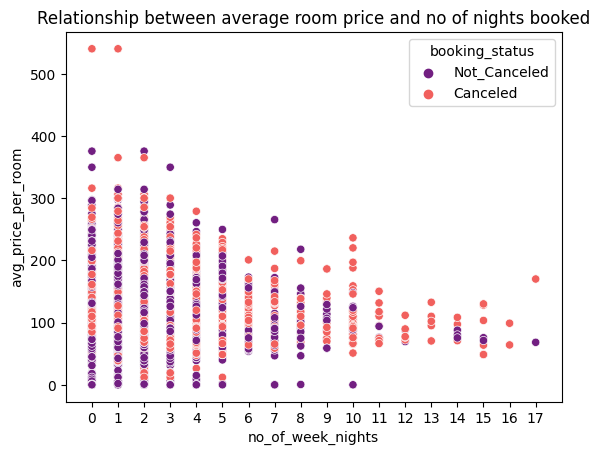

In [12]:
# create a scatterplot to see if there is a relationship between number of nights booked and average room price
plot6 = sns.scatterplot(data=hotels_clean, x='no_of_week_nights', y='avg_price_per_room', hue='booking_status', palette='magma')
plot7 = sns.scatterplot(data=hotels_clean, x='no_of_weekend_nights', y='avg_price_per_room', hue='booking_status', palette='magma', legend=False)

plot6.set_title('Relationship between average room price and no of nights booked')
plot6.set_xlim(-1,18)
plot6.set_xticks(range(0,18))

Text(0.5, 1.0, 'Number of bookings with special requests (cancelled vs not-canceled)')

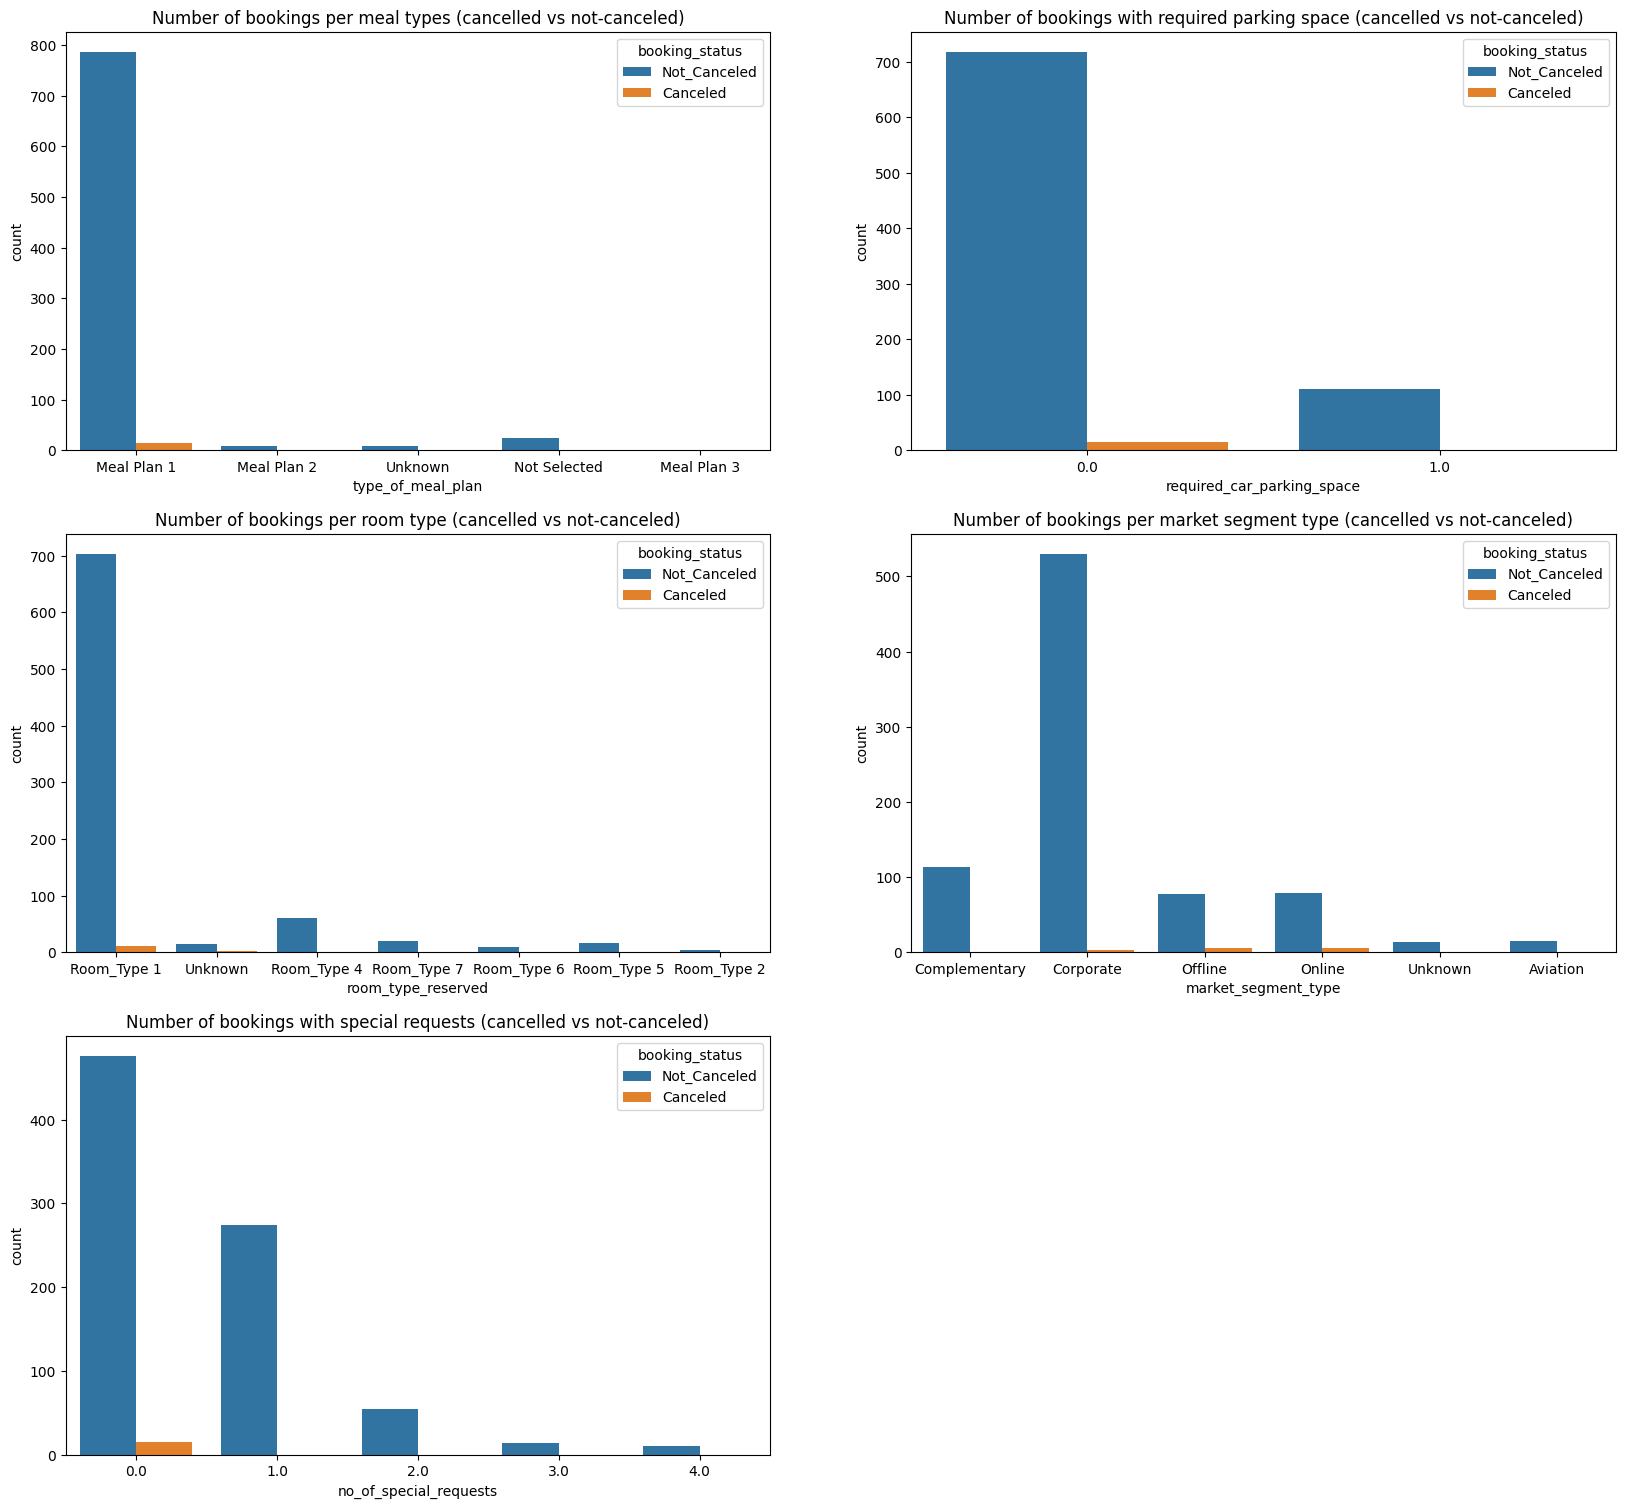

In [13]:
# create histograms to see what the distribution of categories for repeated guests are
repeat_guests = hotels_clean[hotels_clean['repeated_guest'] == 1]

plt.figure(figsize = (20,25))

plt.subplot(4,2,1)
sns.countplot(data=repeat_guests, x='type_of_meal_plan', hue='booking_status')
plt.title('Number of bookings per meal types (cancelled vs not-canceled)')

plt.subplot(4,2,2)
sns.countplot(data=repeat_guests, x='required_car_parking_space', hue='booking_status')
plt.title('Number of bookings with required parking space (cancelled vs not-canceled)')

plt.subplot(4,2,3)
sns.countplot(data=repeat_guests, x='room_type_reserved', hue='booking_status')
plt.title('Number of bookings per room type (cancelled vs not-canceled)')

plt.subplot(4,2,4)
sns.countplot(data=repeat_guests, x='market_segment_type', hue='booking_status')
plt.title('Number of bookings per market segment type (cancelled vs not-canceled)')

plt.subplot(4,2,5)
sns.countplot(data=repeat_guests, x='no_of_special_requests', hue='booking_status')
plt.title('Number of bookings with special requests (cancelled vs not-canceled)')

# Conclusion
Based on the information above, we can suggest that the hotel restrict guests from booking rooms more than three months (or 90 days) in advance to reduce the probability that it might get cancelled. Since most customers use the online resource to make bookings, it would be appropriate to spend time on improving the process to reduce the number of errors in bookings. It seems like guests prefer a certain room type more than others, and the hotel could benefit from investigating the reasons behind why that room type is popular. Changing the other room types to be more like the most popular room type will possibly attract more customers or change one time customers into returning customers. It is also clear that businesses make up the largest majority of repeat customers, so attracting more businesses would be ideal to increase the number of repeat customers.